This Jupyter notebook is a property of the University of California and copyrighted by Dipak Ghosal. Only personal use for ECS 132 and ECS 256 classes is allowed. Uploading this to any shared site is a violation of the University of California copyright laws

# A Project on Covert Timing Channels

## Instructions

    1. You may in no circumstances upload this project to private tutoring websites such as CourseHero or Chegg. Remember all material related to this course  is a property of the University of California and posting them is a violation of the copyright laws and will lead to serious consequences. 
    
    2. In doing this project if you refer to a source (either a book or the internet), you must cite it.
    
    3. You are highly urged to work on this project on your own.  If you do discuss with others,  you must list their names. 
    
    4. This Jupyter Notebook requires Python 3 ipykernel. You  must write your code in Python 3. Make sure to run this notebook under the Python kernel.

## 1. Introduction
The goal of this project is to learn about how to design, detect, and implement a covert timing channel using a stream of packets generated by an application.  We will do this project in steps.  The remainder of this document is organized as follows.

[Background](#2-background)

## 2. Background

Covert communication is method of exchanging secret messages in which the communication is hidden. A related term is steganography which  deals with methods  to write/embed hidden messages in such a way that no one, other than the sender and the intended receiver, know the existence of the message. The word steganography is of Greek origin and means "concealed writing" from the Greek words steganos meaning "covered or protected", and graphei meaning "writing" [From Wikipedia]. Steganography and covert channels have a long history and was used  in WWII to send secret messages to spies behind enemy lines. In computer and network security, covert channels and steganography  fall in the broad category of **security through obscurity**.

The advantage of a covert channel over cryptography is that messages do not attract attention to themselves. Plainly visible encrypted messages — no matter how unbreakable — will arouse suspicion. The very presence of encrypted messages may be incriminating in countries where encryption is illegal. In such cases the communication channel must itself be hidden and this is achieved using covert channels/steganography. Note that, cryptography protects the contents of a message. Covert communication on the other hand attempts protects both the message and the communicating parties.

Typically, steganography refers to the concealment of information within a document file, image file, or program. Media files are ideal for steganographic transmission because of their large size. As a simple example, a sender might start with an innocuous image file and adjust the color of every 100th pixel to correspond to a letter in the alphabet. The overall change is so small  that someone not specifically looking for it is unlikely to notice it. Another method is called the Least Significant Bit (LSB) substitution. In this method, the least significant bit of each  pixel in a digital image is modified by the bits  of the secret message. Since the LSB contributes very little to the overall (intensity/color/brightness) of each pixel, the change in the image will be imperceptible to the naked eye.

Covert channels are communication channels that are established over some overt medium. For example, we can uses a stream of network packets (for example stream of packets generated by a Skype call) as the overt carrier for a covert communication channel. As usual, we have our three characters Alice, Bob, and Eve. Alice and Bob live in a repressive country where all communication is monitored by a warden (Eve). Alice and Bob want to establish a covert channel to exchange secret messages which are sequences of binary digits 0 and 1. Eve can look at all network packets and try to detect if any covert communication is being used to plan a uprising against the repressive state.

To setup a covert communication channel, Alice and Bob first initiate an overt application let say a (computer to computer) Skype call and they start a regular innocuous conversation. Their interactive conversation produces a stream of IP packets from Alice to Bob and Bob to Alice.  For the time being let us only consider covert channel in one direction from Alice to Bob and hence only consider the IP packets stream from Alice to Bob. 

There are two ways in which Alice can send a secret message. She can replace some unused bits in the protocol header with the bits of the covert message. This is called a **covert storage channel**. These types of channels are easily detectable since the protocol header fields that are not used are well known to Eve and she can check bits to detect the covert channel, identify Alice and Bob and the covert message. The other method that Alice can uses is to alter the inter-packet delays of the IP packets, i.e., alter the time between the IP packets. This is called a **covert timing channel** and will be the focus of our study.  

## 3. A Concrete Example

Lets consider a concrete example. For simplicity, we will assume that Alice and Bob are using an application (Skype call) that generates packets in both directions.   Let's consider the packets that are generated by Alice and sent to Bob.  

Each packet has two attributes 1) a sequence number and 2) the time when the packet was generated. Thus, P(n, tn) denotes packet n which was generated at time tn. We will assume that the first packet is numbered 1 and is generated at  time 0, i.e.,  t1 = 0. Note that the time field gives the cumulative time. To obtain the inter-packet delay, we can take the time difference between the consecutive packets.  This packet stream is called the overt traffic. 

In the following discussion we  will assume that  Alice has buffered (stored) a number of packets generated by the application and she can release the packets to send to Bob following some method she and Bob has decided. 

Alice and Bob have *a priori* decided that an inter-packet delay of 0.5 ms  will  be used to code bit 1 and an inter-packet delay of 0.1 ms will be used to code a bit 0. So if Alice wants to code the character “b” (which is 0110 0010) she will release packets from the buffer in the following sequence: P(1, T1), P(2, T2=T1+0.1), P(3, T3=T2+0.5), P(4, T4 = T3+0.1), P(5, T5 = T4+0.1) for the first 4 bits starting from the LSB.  This  is shown in the Figure below. 

The packet stream generated by Alice that encodes the secret message in the inter-packet delays is called the covert traffic. 

<figure> 
    <img src="Figures/Timing-Channel-Example.jpg" width="800" height="600">
    <figcaption align = "center"><b>Figure - A very simplistic timing channel </b></figcaption>
</figure>


If the timing between the packets are not altered by the network or by Eve, then Bob will observe  the inter-packet a delay of 0.1 ms (between P1 and P2), 0.5 ms (between P2 and P3), 0.1 ms (between P3 and P4), 0.1 ms (between P4 and P5). Bob can translate them to binary  bits 0010 and thus retrieve the first 4 bits of the character "b".  


In this project, we will try to design a method of coding the bits into inter-packet delays such that Eve is not able to discover the covert communication channel. We will assume that the network or Eve will not modify the inter-packet delays.

## 4.  A First Simple Design

Alice ad Bob are having a Skype call. When Alice talks, the Skype application generates a sequence of packets. This is  the overt traffic (also referred to as the overt packet stream). In her computer Alice stores a bunch of the packets (as many as required to send the secret message) in  memory. Then using a specially designed packet scheduler releases the packets one at a time following an encoding scheme that maps bits 0 and 1 to inter-packet delays.  The overall system in Alice's computer is shown in the Figure below.  In this part of the project we  will consider a few simple scheme for encoding a secret message in the inter-packet delays. 

<figure> 
    <img src="Figures/Timing-Channel-Alice.jpg" width="800" height="600">
    <figcaption align = "center"><b>Figure showing the setup in Alice's computer. The overt stream of packets is generated by the Skype application. The inter-packet delays has some (given)  random distribution. The covert packet stream is generated by the packet scheduler. The inter-packet delays are chosen such that they encode the secret message.  </b></figcaption>
</figure>



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 4.1 Secret Message 

The secret message that Alice wants to send to Bob  is \``this is a secret message\''  The characters are encoded using 8 bits ASCII. Write a code to convert  the secret message into a sequence of bits. Include the spaces as well but not the end quotes. You can use the bin and ord  functions as shown below.  

In [ ]:
bin(ord("t"))

'0b1110100'

You can remove the 'b' 

In [ ]:
bin(ord("t")).replace('b','')

'01110100'

#### 1. Include the code that generates the bit sequence corresponding to the secret message. Your code should generate a sequence of binary bits corresponding to the secret message. Also write it  in a file named "secret_message_bits" one bit per line. Put the code in a new cell below.


In [22]:
message = "this is a secret message"

bits = []
for i in range(len(message) - 1):
  temp = message[i]
  temp_bit = bin(ord(temp)).replace('b','')
  for j in range(len(temp_bit)-1):
    bits.append(temp_bit[j])

secrete_message_bit = pd.DataFrame({
    'Bit pattern': bits
})

# Save to CSV
secrete_message_bit.to_csv('secrete_message_bits.csv', index=False)

### 4.2 Obtaining the Baseline

We assume that we have a sample of packets that was generated by Skype when Alice and Bob were 
talking without exchanging any secret message. This is the baseline data that is available to Alice and Bob and also to Eve. For this part of the project we will consider the packet stream that is given in the  excel file as the baseline data.  The name of the file is Traffic_data_origin.csv. You  will find the file in the Data sub-folder in the Notebooks folder. The data contains packet numbers and the times when the packets were generated. 


Note that Alice will encode the bits of the secret message by modifying  inter-packet delays. Also,  Eve will will look  into the inter-packet delays, specifically, the distribution (histogram) of the inter-packet delays  to detect any covert communication between Alice and Bob. 

Given the above, let's review Alice's goal and Eve's task. 

1. Alice's Goal: Alice ofcourse knows the distribution of the inter-packet delay of the baseline. Again baseline means when Bob and she and Bob communicate without exchanging any secret message. When she wants to send a secret message she will alter the inter-packet delays to encode the secret bits using a encoding scheme. Her goal is to design a encoding  scheme for which the distribution (histogram) of the inter-packet delays of the packet stream carrying the secret message is as similar as that of the baseline and hence Eve will not flag it as suspicious. 

2. Eve's Tasks: Eve also knows the distribution of the inter-packet delay of the baseline. Whenever Alice and Bob talk, she will 1) monitor the packet stream, 2) extract the inter-packet delays and determine the distribution (histogram) and 3) compare with distribution (histogram) of the baseline and flag it to be suspicious if the distributions are very different. In Section 7 (Detection),  we will learn of techniques of how  Eve will actually do this. 


Write a Python code to plot the histogram of the **inter-packet delays** of the baseline packet stream.  

#### 2. Include the code that generates the histogram  of the inter-packet delays of the baseline packet stream. Put the code in a new code cell below. 

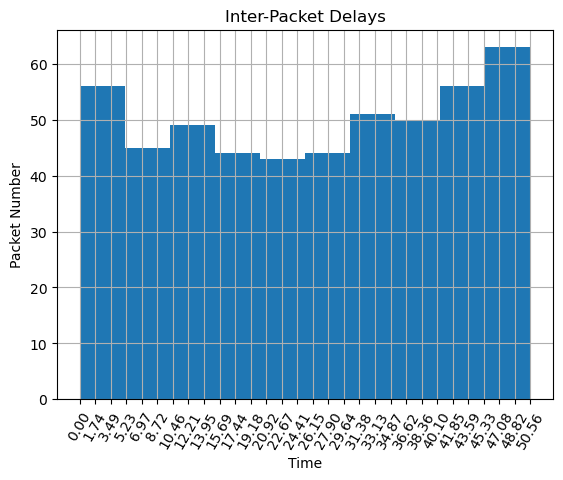

In [23]:
data = pd.read_csv('Data/Traffic_data_orig.csv')

plt.hist(data['Time'])
plt.title('Inter-Packet Delays')
plt.xlabel('Time')
plt.ylabel('Packet Number')
plt.xticks(np.linspace(data['Time'].min(), data['Time'].max(), num=30), rotation=60)
plt.grid(True)
plt.savefig('inter-packet_delays(traffic_data_orig).png')

#### 3. Include the histogram (jpeg or pdf). You run the above code. Save the histogram as a pdf of jpeg file and then load it in a new markdown cell below. 

![Histogram of Inter-Packet Delays](inter-packet_delays\(traffic_data_orig\).png)

### 4.3 A Simple Encoding Scheme

Alice and Bob decide to use the following encoding scheme to map the bits to the inter-packet delay. 

An inter-packet delay of 0.25 is used to encode a bit 0 

An inter-packet delay of 0.75 is used to encode a bit 1 


Write a Python code  that will generate the modified packet stream that contains the secret message.  Note that if $n$ is the number of secret bits you will need $n+1$ packets. Your code should generate a sequence of packets and their corresponding times and write in a file. Name the file Covert_Traffic_Data.csv. The file will contain 2 columns - packet number and the time. Assume first packet (P1) is sent at time 0. 

#### 4. Include the code that generates the file Covert_Traffic_Data.csv in the new cell below. 

In [24]:
secrete_message_bits = pd.read_csv('secrete_message_bits.csv')
bits = secrete_message_bits['Bit pattern']
time_delay = [0]
packet_num = [1]

for i in range(len(bits) - 1):
  if bits[i] == 0:
    time_delay.append(time_delay[-1] + 0.25)
  elif bits[i] == 1:
    time_delay.append(time_delay[-1] + 0.75)
  packet_num.append(i+2)
  
convert_traffic_data = pd.DataFrame({
    'Packet number': packet_num,
    'Time': time_delay
})

# Save to CSV
convert_traffic_data.to_csv('convert_traffic_data.csv', index=False)

### 4.4 Histogram of Inter-packet Delays of the Covert Stream

We will now plot the histogram of the inter-packet delays of the covert packet stream, i.e., the histogram inter-packet delays from the packet stream  in the file Covert_Traffic_Data.csv.

#### 5. Include the code that generates the histogram of the inter-packet delay from the data in the file Covert_Traffic_Data.csv. Put this code in a new code cell below. 

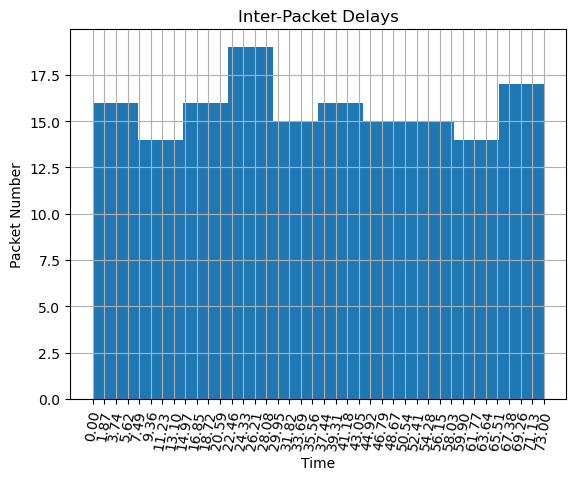

In [25]:
data = pd.read_csv('convert_traffic_data.csv')

plt.hist(data['Time'])
plt.title('Inter-Packet Delays')
plt.xlabel('Time')
plt.ylabel('Packet Number')
plt.xticks(np.linspace(data['Time'].min(), data['Time'].max(), num=40), rotation=80)
plt.grid(True)
plt.savefig('inter-packet_delays(convert_traffic_data).png')

#### 6. Include the histogram (jpeg or pdf) of the inter-packet delays in the new markdown cell below. 

![histogram of Inter-packet_delays based on convert_traffic_data](inter-packet_delays\(convert_traffic_data\).png)

#### 7. Eve will compare the histogram in 6 with that of 3. Will Eve be suspicious? Briefly explain why? Answer in a new markdown cell below. 

- Eve will be suspicious of course. First of all, the time that takes to sent all the packages are different and the packet flow at each point are slightly different, but both are quite obvious to see especially when convert them into histograms.

### 4.5  A Better Modulation Scheme

Alice and Bob decide to use the following modulation scheme. 

Let $m$, $\min$, and $\max$ denote the median, min, and max of the inter-packet delay of the overt packet stream. 

1) If Alice needs to send a 0 she randomly generates a delay between $m$ and $\min$. 

2) If she want to send a 1 she randomly generates a delay between $m$ and $\max$. First, compute $m$, $\min$, and $\max$ of the overt packet stream. 


Next, modify the code  in  4.3, to generate  the covert  packet stream that contains  the secret message.

#### 8. Include the code (in a new code cell below) that will that generates the Covert_Traffic_Data-V2.csv. 

In [ ]:
secrete_message_bits = pd.read_csv('secrete_message_bits.csv')
bits = secrete_message_bits['Bit pattern'].tolist()

traffic_data = pd.read_csv('Data/Traffic_data_orig.csv')
orig_times = traffic_data['Time'].tolist()
packet_num = traffic_data['Packet Number'].tolist()

convert_times = orig_times.copy()
# print(convert_times)


for i in range(len(bits)):
  convert_delay = np.diff(convert_times)
  # print(convert_delay)

  # Finding the median and max
  m_index = len(convert_times) // 2
  maxi = len(convert_times) - 1

  # Finding the randomly selected insert positive and the exact time delay
  if bits[i] == 0:
    insert = np.random.randint(0, m_index + 1)
    inserted_delay = 0.25
  elif bits[i] == 1:
    insert = np.random.randint(m_index, maxi + 1)
    inserted_delay = 0.75

  # Insert new packet time
  if insert == 0:
      new_time = convert_times[0]  # start time=0 if insert at the beginning
  else:
      new_time = convert_times[insert - 1] + inserted_delay
  convert_times.insert(insert, new_time)
  
  # Insert the new time
  packet_num.insert(insert, insert + 1)
  # increse the size by one
  for j in range(insert + 1, len(packet_num)):
      packet_num[j] += 1
  
  # update all the followings by the delay time
  for j in range(insert + 1, len(convert_times)):
      convert_times[j] += inserted_delay
  
# Setting up the new CSV
convert_traffic_data_V2 = pd.DataFrame({
    'Packet number': packet_num,
    'Time': convert_times
})

convert_traffic_data_V2.to_csv('convert_traffic_data-V2.csv', index=False)

### 4.6 Histogram of Inter-packet Delays

Plot the histogram  of the inter-packet  delays of the overt packet stream and that of the new covert packet stream. Again, plot the histogram of the part of the packet stream that you need to encode the secret message. Do you think Eve will be suspicious?

#### 9. Include the code that generates the histogram  of the inter-packet delays from Covert_Traffic_Data-V2.csv.  Put the code in a new code cell below. 

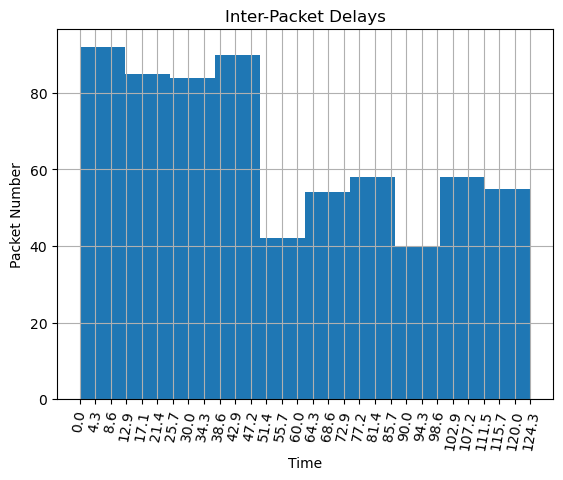

In [27]:
data = pd.read_csv('convert_traffic_data-V2.csv')

plt.hist(data['Time'])
plt.title('Inter-Packet Delays')
plt.xlabel('Time')
plt.ylabel('Packet Number')
plt.xticks(np.linspace(data['Time'].min(), data['Time'].max(), num=30), rotation=80)
plt.grid(True)
plt.savefig('inter-packet_delays(convert_traffic_data_V2).png')

#### 10. Include the histogram (jpeg or pdf) of the inter-packet delays from the packet stream in the file Covert_Traffic_Data-V2.csv. Put the histogram in new markdown cell below. 

![Inter Packet Delays from convert_traffic_data_V2.csv](inter-packet_delays\(convert_Traffic_data_V2\).png)

#### 11. Is this new scheme better? Briefly explain why? Put your answer in a new markdown cell below. 

- This is even worse.

### 4.7 Propose and Evaluate Your Method 

For steps 12, 13, and 14, write your answer in a new markdown cell after each question. 


#### 12. How can you improve upon the method in 4.5? Propose your scheme and plot the histogram of the covert packet stream. 

#### 13. In this first simple scheme we have implicitly assumed the Alice will buffer up the required number of packets and release them  and we mentioned that it was unrealistic. Why?


##### 12 Answer
- I figured that when inserting the secrete message bit into the original stream, we are selecting points between min and median or median and max based on the secrete message bit is 0 or 1. which makes the inserted stream hard to control if we are to escape from Eve (who is monitoring the stream). As we can see, in the below histogram, the pattern has been changed extremely and we can't even countrol that, so if someone is monitoring the stream, it would be so easy for him/her to see there are something else happening. Thus, if we can divide the stream up into pieces and track the number of packets in each parts, and keep that same pattern when we insert our secrete message bits, it would be harder to track. Though the randomness in 4.5 should be retained to make the decoding as difficult for other people.

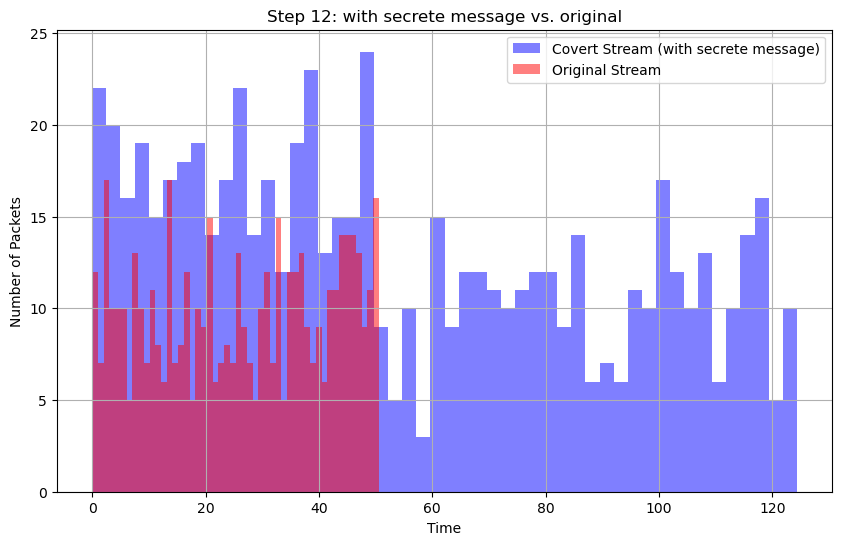

In [ ]:
# Step 12 - Answer
covert_data = pd.read_csv('convert_traffic_data-V2.csv')
covert_times = covert_data['Time'].tolist()

orig_data = pd.read_csv('Data/Traffic_data_orig.csv')
orig_times = orig_data['Time'].tolist()


plt.figure(figsize=(10, 6))
plt.hist(covert_times, bins=50, color='blue', alpha=0.5, label='Covert Stream (with secrete message)')
plt.hist(orig_times, bins=50, color='red', alpha=0.5, label='Original Stream')


plt.xlabel('Time')
plt.ylabel('Number of Packets')
plt.title('Step 12: with secrete message vs. original')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

##### 13 - Answer
- If we are tracking the time delays, adding whatever message will influence that, so no matter how to buffer things up, impacts are still there, delays won't get eliminated. Thus it is unrealistic. 

#### 14. We have assumed that the network does not alter the inter-packet delays. What would be the problem if it did? Can you suggest methods to mitigate the effect of the changes in the inter-packet delays (noise)?

##### 14 - Answer
- If the network does alter the inter-packet delays, then the secret message that we insert into the original stream would be destroyed. Since the way we distinguish the secret message and others are by the time delays, and if the network alter the inter-packet delays, we will lost track of the pattern which will make us lost track of the secret message.
- one way of mitigate the this effect is that since we will lost track of the message bits, we can simply repeat the bits multiple times, and keep the repeat time as the pattern, so when we trying to decode the stream, we just need to look at the bits that are redundent and apply the algorithm for times of repeating to decode the bits to get our secret message.

## 5. A Real Implementation

In this section, we make the implementation more realistics and address some engineering issues.  

### 5.1 Overview

In the previous part, we assumed that Alice buffers as many packets she requires to transmit the secret message. For example, if the secret message is 32 bits then Alice will buffer 33 packets and release the packets with appropriate delays based on the encoding scheme to encode the secret message. If the secret message is small, this will work as Alice needs to buffer a small number of packets. However, this will not work if the secret message is long as this will require Alice to buffer large number of packets and this is unealistic (you have found and written good reasons in answering the related question in 4.7 above). 


We will denote $m$ to be the size of the secret message. Also let $B$ denote the maximum number of packets that can be buffered at anytime. The issue of having a large $B$ is that packets that are at the end of the buffer  must wait for all the packets that in the front to be transmitted. This may cause unacceptable delays for the packets. The value of $B$ will be determined by the overt application that ALice is using. For example, for real-time application (such as Augmented Reality/Virtual Reality applications) $B$ will be small whereas for Email application $B$ can be large.   In this study we will consider different values of $m$ and $B$ with $m \geq B$ and Alice, Eve and Bob know the value of $B$ since they all know what is the overt application Alice is using. 

Given $m$ and $B$ what should be Alice's strategy be to tranmit the secret message? There are two important constraints: 

1. Alice cannot buffer more than $B$ packets because of the reason above.
2. Once she starts to transmit the secret message she cannot stop (because she has no way of letting Bob know). She must try to compelete sending the entire secret message.

Alice follows the following strategy. Before starting to transmit the secret message she buffers $i$ ($0 \geq i \leq B$) packets and then starts to release the packets to transmit the secret message. In order to determine what should $i$ be we need to discuss two system states that we need to worry about - buffer overflow and buffer underflow. Let's understand what these are, why these can occur and what are the factors that determine when they will occur. 


1. **Buffer Overflow**: This happens when the buffer already has $B$ packets and another packet arrives from the application. Recall we have said that the number of packets in the buffer cannot exceed $B$. To build  intuition as to when this happens let's consider a specific scenario. Suppose we have set $B = 10$, $m = 32$ and $i=8$. Since $i = 8$,  Alice will first buffer 8 packets. As soon as the 8th packet arrives from the application, she will start transmitting packets with inter-packet delays that encode the secret message.  While she release the packet from the buffer, new packets may arrive from the application that will be appended to the buffer. So the number of packets in the buffer will keep changing - decrease when a packet is transmitted and increase when a packet is generated by the application. Suppose at some time there 7 packets in the buffer and before the next packet is to be transmitted 4 packets arrive in quick succession from the application. This will cause the number of packets in the buffer to go beyond 10 and that will be a violation of policy at most 10 packets can be buffered. Essentially, if packets arrive faster than they are transmitted out, there will be buffer overflow. If $i$ is set close to $B$ there is likely to be an overflow. 


2. **Buffer Underflow**: This happens when a packet must be transmitted (to encode a bit of the secret message) but there are no packets in the buffer. Recall the constraint that once Alice starts to transmit the secret message she cannot stop. Hence, if packets arrive slower than they are transmitted there is likely  be buffer underflow. If $i$ is set close to 0, there is likely to be an underflow. 


**If either of the above two cases (buffer overflow and buffer underflow) arise during the process of sending the secret message we will consider that to be a failure of the covert channel. 


There are many factors that will determine if the covert channel will go into overflow and underflow. These include $m$, $B$, $i$, distribution of the inter-packet delay of the overt application, and the encoding scheme. In this part of the project we will write a simulation to study some of the above factors on the success of transmitting a secret message.  The overall sender-side system is shown in the Figure below. 


<figure> 
    <img src="Figures/ctc-implementation.jpg" width="600" height="400">
    <figcaption align = "center"><b>The overall system diagram of the source and the covert sender. </b></figcaption>
</figure>



### 5.2 Assumptions

  1. We will consider that the source generates packet following well-known IPD distributions. Specifically, we will consider two cases a) Exponential and b) Uniform. The sender (Alice) also knows this distribution and follows it to inject the delay between the packets to embed the secret message. It is important to note that the source and the sender are independent. Hence, even though they follow the same distribution,  the sequence of delays generated by the source will be different from the sequence of delays generated by the sender.
  
  2. To embed a 0, the sender generates a delay between the minimum value (min) and the median. To embed a 1 the sender generates a delay between the median value and the maximum value (max). Note that  for the Uniform distribution the min, max and median are easy to determine. For the Exponential distribution min is 0, the max is $\infty$. What is the median value of an Exponential distribution with rate parameter $\lambda$ pkts/sec?
  
  3. The secret message is a randomly generated sequence of 1s and 0s of size $m$ bits and is given. We will consider two values $m=16, 32$.
  
  4. The sender has a buffer of size $B$ and initially the sender buffers $i$ packets before starting to send the secret message.
  

### 5.3 Project Steps 

  1. For  buffer size $B=20$ we want to find out the probability of overflow  and  underflow, when the IPD follows the Exponential with $\lambda =1$ pkts/sec and $i=2, 6, 10, 14, 18$. Use message size $m = 16, 32$ bits. Tabulate the results. Remember that to determine the probability you need to run multiple (say 500) experiments for each parameter, i.e., for $B = 20, m = 16, i = 2$ run 500 experiments  and determine the probability of overflow and underflow. Similarly for other values of $i$ and $m$. The max value of an Exponential distribution is $\infty$. For this study  we can limit the max value to say 5 ~secs$. 
  
  2. For  buffer size $B=20$ we want to find out the probability of overflow  and  underflow, when the IPD follows the Uniform distribution in the range (0,1)  and $i=2, 6, 10, 14, 18$. Use message size $m = 16, 32$ bits.  Tabulate the results. Remember that to determine the probability you need to run multiple (say 500) experiments for each parameter, i.e., for $B = 20, m = 16, i = 2$ run 500 experiments  and determine the probability of overflow and underflow. Similarly for other values of $i$ and $m$.

  
  3. Propose methods to deal with buffer overflow and underflow.

### 5.4 Notes on Simulating the Implementation

For steps 1 and 2, since the source and the sender are independent processes, a proper way to simulate would be using a  discrete event simulation module such as simpy in Python.  However, we can simplify and just use standard Python. To do this,  we can pre-generate the times when the source generates packets and store it in a list. Then we can write the code to simulate the buffer, the encoding scheme, and  the sender. This can be done in a single "process." Based on this, following is a very **rough** set of steps to simulate the system.

For each experiment we can break it down to the following steps


 1. Generate the random bit pattern of 1s and 0s of size $m$ which is the secret message.

 2. Generate a sequence of times when the source will generate the packets. This is based inter-packet delay (IPD) distribution of the packets generate by the source. You can intuit what is the worst case number of packets that you need.

 3. For the buffer you need to keep some  variables such as B: buffer size, i: the initial buffer size to start sending he secret message bits and CB: current buffer size.

 4. For the sender you need to maintain some variables such as the time when the next packet will be sent.

 5. For each secret message bit:


       a. Generate a delay following the encoding scheme and hence determine when  the next packet will be transmitted.
       
       b. Update the state of the buffer depending on the number of arrivals during that time.
       
       c. At appropriate places check for buffer underflow and overflow and break out if it is the case.
       
       d. Appropriately update the current time.


  6. Do the experiment multiple times to calculate the different probabilities.
  

#### 15. Include the code that you used to generate the results for Steps 1 and 2.  You should write only one code with the distribution of the inter-packet delays chosen as a parameter. Put your code in a new code cell below. 

In [ ]:
# Setting up a randome message bit pattern, length = 256
random_bits = np.random.randint(0, 2, size=256)
bits_df = pd.DataFrame({
    'Bit pattern': random_bits
})
bits_df.to_csv('random_message_bit.csv', index=False)


In [38]:
# Applying the same inserting scheme, inserting the previous random_message_bit into the traffic_data_orig
random_bits = pd.read_csv('random_message_bit.csv')
random_bit = random_bits['Bit pattern'].tolist()

traffic_data = pd.read_csv('Data/Traffic_data_orig.csv')
orig_times = traffic_data['Time'].tolist()
packet_numb = traffic_data['Packet Number'].tolist()

converted_times = orig_times.copy()

minimum = 1

for i in range(0, len(random_bit)-1):

    median = len(random_bit) // 2
    max = len(random_bit) - 1

    if random_bit[i] == 0:
        delay = 0.25
        insert_position = np.random.randint(minimum, median)
    elif random_bit[i] == 1:
        delay = 0.75
        insert_position = np.random.randint(median, max)

    updated_time = converted_times[insert_position-1] + delay
    converted_times.insert(insert_position, updated_time)
    packet_numb.insert(insert_position, insert_position + 1)

    for j in range(insert_position + 1, len(packet_numb)):
        packet_numb[j] += 1
  
    for j in range(insert_position + 1, len(converted_times)):
        converted_times[j] += delay
  
# print (len(packet_numb))
# print (len(converted_times))

random_traffic_data = pd.DataFrame({
    'Packet number': packet_numb,
    'Time': converted_times
})

random_traffic_data.to_csv('random_traffic_data.csv', index=False)

#### 16. Table of results here for Step 1 (IPDs follow Exponential Distribution). Put the table in a new Markdown cell below. 

[Random Message Bit Pattern](random_message_bit.csv)

#### 17. Table of results here for Step 2. (IPDs follow Uniform Distribution). Put the table in a new Markdown cell below. 

[Traffic Data with Random Message Bit Pattern Inserted](random_traffic_data.csv)

Sample Results for Steps 1 and 2. 

Source Distribution = Exponential
M Size      i             Underflow         Overflow      Success  
16           2             0.382              0.134        0.484    
16           6             0.058              0.294        0.648    
16           10            0.006              0.524        0.470    
16           14            0.000              0.710        0.290    
16           18            0.000              0.876        0.124    
32           2             0.404              0.400        0.196    
32           6             0.062              0.664        0.274    
32           10            0.014              0.830        0.156    
32           14            0.000              0.906        0.094    
32           18            0.000              0.958        0.042    



Source Distribution = Uniform
M Size      i             Underflow         Overflow      Success  
16           2             0.652              0.000        0.348    
16           6             0.080              0.000        0.920    
16           10            0.000              0.000        1.000    
16           14            0.000              0.040        0.960    
16           18            0.000              0.330        0.670    
32           2             0.772              0.000        0.228    
32           6             0.238              0.004        0.758    
32           10            0.024              0.022        0.954    
32           14            0.002              0.158        0.840    
32           18            0.000              0.460        0.540 

#### 18. Can you propose one scheme to deal with buffer overflows and underflows? Write you answer in a new markdown cell below. 

- Based on the sample results for Step1 and 2, we can see that when using uniform distribution, we are getting a higher success rate. We also know that uniform and exponential has different scale, which is basically where the difference came from. A more detailed support of what I just said is that when we look into the underflow column, we can see that exponential sometimes have lower underflow rate than uniform distribution that is because the delay scale reserved in exponential is smaller than in uniform which overcomes the underflow because input size is equal or larger than the reserved slot, and similarly, since uniform distribution creates larger scale, overflows are somehow overcomed.
- The reason I claimed that Exponential distribution is having smaller reserved slot than uniform distribution even though the range of exponential (0, $\infty$) is larger than the range of uniform (0, 1) is because exponential is using an unbalanced separation.
- Therefore, we can simply combine the strength of both distribution, having a uniform distribution of wider range.

- However, I don't really think that underflows and overflows are directly caused by the unbalanced separation or a small range. Since underflow and overflow occurs because the input size doesn't match the reserved size. so we can dynamically check for input size and dynamically change the reserved time, and apply pipeline here, so ideally we will only need stalls after the first check, and then while we change the first reserved time, we are doing the check for the second input, and so on... which will best reduce the underflows and overflows.

#### 19. Give a version of the code that I can run for different values of the parameters, namely, 1) inter-packet delay distribution (Uniform or Exponential), 2) size of the secret message and 3) value of $i$. Name the file "real_implementation_code.py."  Your code should ask for the three inputs and output the Underflow, Overflow, and Success probabilities. 

Write how to run the code in the new markdown cell below.  

- `python real_implementation_code.py`

## 6 Detection 

In this section we will investigate some simple appropaches to detect timimng channels. This is the task of Eve. 

As mentioned in Section 4.2,  we assume that Eve has a packet stream that is "clean" i.e., it is not modified by a timing channel. Eve can derive many features from this packet stream. One that we have focussed in Section 4.2 is the distribution of the inter-packet delay. (You may reflect on what other fetaures you could consider.)

Given the baseline inter-packet delay distribution, what Eve will do is the following 

1. Take a sample of the packet stream when Alice and Bob talk
2. Extract the inter-packet delay distribution
3. Compare with the baseline 
4. Flag if the distributions are different

There are many engineering issues with each of the above steps but here we will focus on Steps 3 and 4. The basic problem is the following. We have two sets of inter-packet delay samples. We want to know if they are from the same distribution. You can guess that this must be common problem and there must be many different approaches. Yes there are many methods. There are qualitative approcheas such as l comparing the boxplots, the cummulative distribution finctions, the histograms, the Q-Q plot, and the Kernel density functions. There are quantitative statistical test such the T-test, Mann–Whitney U Test, the Kolmogorov–Smirnov test, among others.  For this project we will focus on the Q-Q plot. 

### 6.1 Q-Q Plot

In Q-Q plot \[Q stands for quantile\], the quantiles of the two distributions are plotted against each other. If the distributions are the same, we should get a 45-degree line.

We will use two Python modules numpy and statsmodels.  You must install these modules either using pip3 or  conda. 

The basic function is qqplot. It by default plots quantiles with respect to quantiles of the standard normal (Z) distribution. 


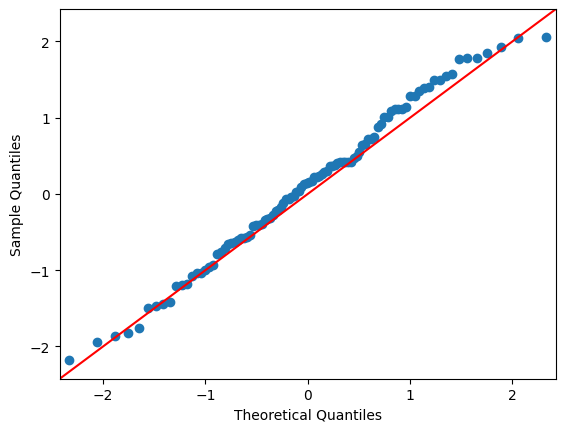

In [18]:
import numpy as np
import statsmodels.api as sm
import pylab as py
  
# Generate 100 samples from a standard normal (Z) distribution
sample_data1 = np.random.normal(0, 1, 100)
sm.qqplot(sample_data1, line ='45')
py.show()


\[ I have not figured out how to resolve the warning. If someone does, please let me know\]

In the above code see what happens when you increase the number of samples to 1000 and then to 10000. 

Next we generate sample from an Exponential distribution  with rate $\lambda =1 $  and get the Q-Q plot. 

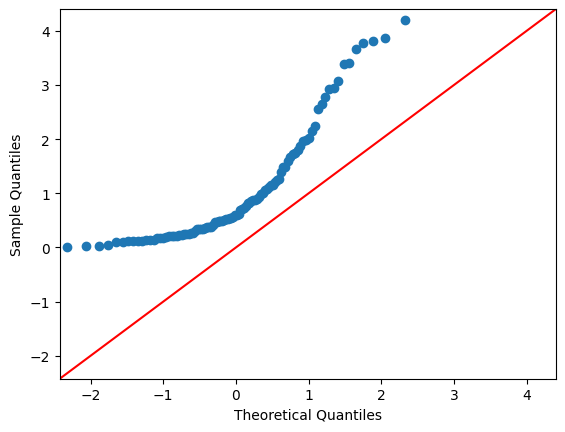

In [20]:
# Generate 100 samples from an exponential distribution with rate $\lambda =1 $
sample_data1 = np.random.exponential(1, 100)
sm.qqplot(sample_data1, line ='45')
py.show()

### 6.2 Q-Q Plot with 2 Samples 

qqplot_2samples gives the Q-Q plots for the quantiles derived from two data sets. We will consider the size of both samples to be the same althougth it is not required. In the following code see what happens as you increase the number of samples

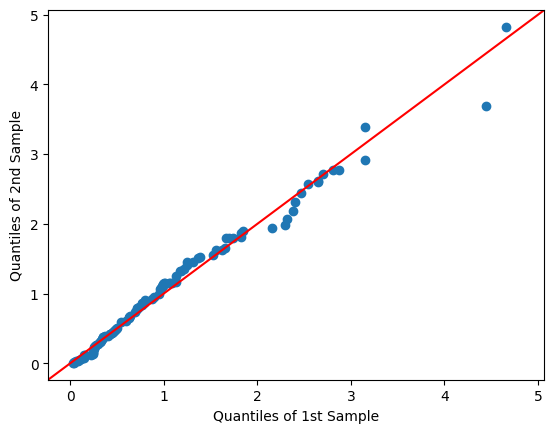

In [21]:
# Generate 100 samples from an exponential distribution with rate $\lambda =1 $
sample_data1 = np.random.exponential(1, 100)
# Generate another 100 samples from the  exponential distribution with rate $\lambda =1 $
sample_data2 = np.random.exponential(1, 100)
sm.qqplot_2samples(sample_data1, sample_data2, line ='45')
py.show()

### 6.3 A Simple Task

For this project, using the qqplot_2samples, get the Q-Q plot of the inter-packet delays generated in Section 4.5 with that of the baseline. Use only the inter-packet delays that contain the the secret message. Use the same number of inter-packet delays from the baseline traffic. 

22. Include the code and that will generate the plot in a cell below. 

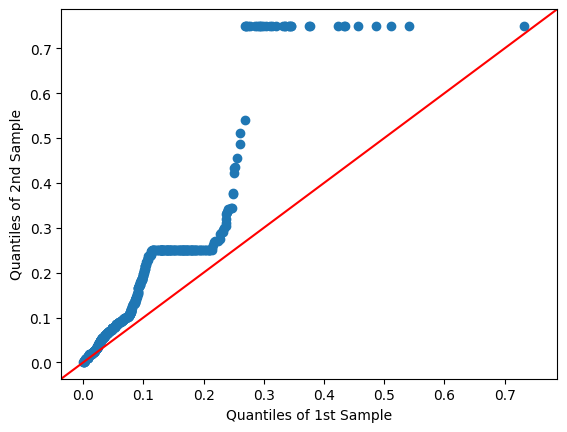

In [50]:
# convert_traffic_data-V2.csv
traffic_data_orig = pd.read_csv('Data/Traffic_data_orig.csv')
orig_data = np.diff(traffic_data_orig['Time'])
convert_traffic_data = pd.read_csv('convert_traffic_data-V2.csv')
convert_data = np.diff(convert_traffic_data['Time'])

# min = __builtins__.min
# accidentally set min=0 in previous part, so if you have problem generating this plot and a TypeError showed up about the below line, uncomment the above line and run again
min_len = min(len(orig_data), len(convert_data))
orig_data = orig_data[:min_len]
convert_data = convert_data[:min_len]

sm.qqplot_2samples(orig_data, convert_data, line ='45')
plt.savefig('inter_packet_delays_qqplot.png')

23. Include the plot (pdf, jpeg, or png) in a new markdown cell below. 

![plot](inter_packet_delays_qqplot.png)

24. Propose a different approach to compare two distributions. An existing statistical method is OK. 
Describe it and use it  compare the baseline with your proposed method in Section 4.7. 

## 7 Finishing up

24. If you have a partner for this project, please put the names of the team members (i.e., both the names if you worked in a team of 2) in new markdown cell below.

25. Please provide  feedback about the project, specifically, how it can be improved.  Please put your comments in a new markdown cell below. 

### Submission and Grading Guidelines 

1. For this project  there is one input file and input figures (the drawings). You will write code  which will generate results, figures, and files. 

2. Put this jupyter notebook, the input file, input figures, the new figures and files you generate in one folder. Make sure that paths are set properly so that the figures will render when I open the notebook. 

3. For Step 18,  you need to include a version of the code that I can run by changing the parameters. See Step 18 for details. 

4. Submit a zipfile of the folder. 

5. If you are working in a team, each member of the team must submit the same zip file. 

6. There may be interactive grading. 